# Business Forecasting using Python
## ADIDAS Revenue

In [111]:
# ! pip install statsmodels
# ! pip install plotly==5.10.0

In [112]:
# Importación de Librerías

import pandas as pd
from pandas import Grouper
import numpy as np
from datetime import date, timedelta
import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import seaborn as sns
from seaborn import distplot


import warnings
warnings.filterwarnings('ignore')

In [113]:
# Llamar la data

data = pd.read_csv("/Users/franciscoletelier/Dropbox (Personal)/MDS - UAI/adidas_data.csv", sep=";")
print(data)

   Time Period  Revenue
0       2000Q1     1517
1       2000Q2     1248
2       2000Q3     1677
3       2000Q4     1393
4       2001Q1     1558
..         ...      ...
83      2020Q4     5142
84      2021Q1     5268
85      2021Q2     5077
86      2021Q3     5752
87      2021Q4     5137

[88 rows x 2 columns]


In [114]:
data.describe()

,Revenue
count,88.000000
mean,3302.034091
std,1477.855719
min,1078.000000
25%,1864.250000
50%,3162.000000
75%,4457.500000
max,6410.000000


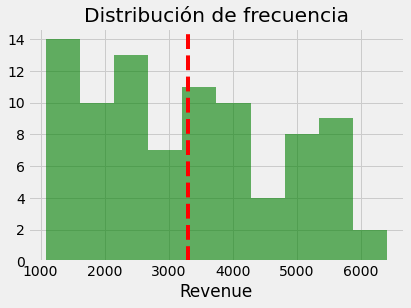

In [115]:
# Distribución de las frecuencia
mean_so = np.mean(data['Revenue'])
#std_so = np.std(data['Revenue'])

data['Revenue'].hist(color='green',alpha=.6)
plt.title('Distribución de frecuencia')
plt.xlabel('Revenue')
plt.axvline(mean_so,color='red',linestyle='--') # Promedio
plt.show();

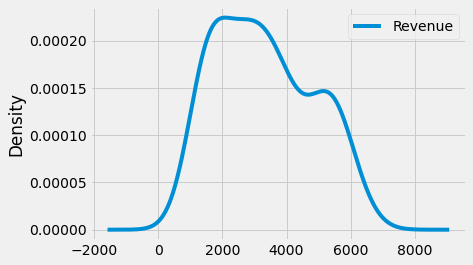

In [116]:
# Vissualización del kernel density
data.plot(kind = 'kde',)
plt.show()

In [117]:
# Evaluación si la serie es estacionaria

from statsmodels.tsa.stattools import adfuller 

adf_data = adfuller(data['Revenue'])
print(adf_data)

(-0.452124330349096, 0.9010254109900224, 7, 80, {'1%': -3.5148692050781247, '5%': -2.8984085156250003, '10%': -2.58643890625}, 1107.7933726964147)


### Conclusión
* No hay evidencia suficiente para rechazar la hipótesis nula, por lo que se concluye que la serie de precio del cobre no sería estacionaria. 
* Se deben transformar los datos para llevarlos a una forma funcional.

In [118]:
# Agrupar los datos por año
groups = data['2000Q1':'2021Q4'].groupby(Grouper(freq='A'))

# Se crea el DataFrame agrupando por año

yr = DataFrame()
for name, group in groups:
    yr[name.year] = group.values

# Gráfico box plot por año

yr.boxplot(figsize = (14,7), color='green')
plt.xticks(rotation=90)
plt.show()

TypeError: cannot do slice indexing on RangeIndex with these indexers [2000Q1] of type str

In [ ]:
# Muestra la dinámica de las ventas
import plotly.express as px
figure = px.line(data, x="Time Period", 
                 y="Revenue", 
                 title='Quarterly Sales Revenue of Adidas in Millions')
figure.show()

<Figure size 432x288 with 0 Axes>

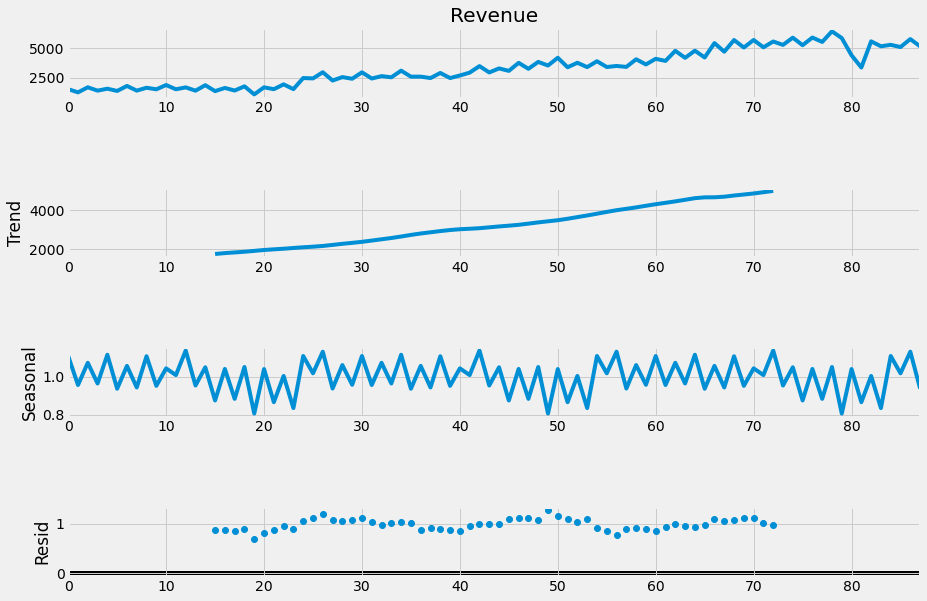

In [ ]:
# Revisión de "estacionalidad" para buscar una serie de tiempo

# result = seasonal_decompose(data["Revenue"], model='multiplicative',freq = 4) --> el parametro freq está deprecado, usar period
result = seasonal_decompose(data["Revenue"], model='multiplicative',period= 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

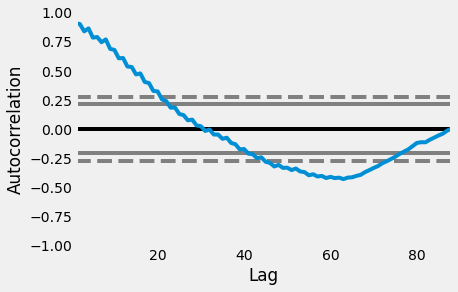

In [ ]:
# Utilizaré el modelo de ARIMA estacional (SARIMA) para pronosticar los ingresos por ventas trimestrales de Adidas. Antes de usar el modelo SARIMA, 
# es necesario encontrar los valores p, d y q
# Como los datos no son estacionarios, el valor de d es 1. Para encontrar los valores de p y q,
# podemos usar los gráficos de autocorrelación y autocorrelación parcial:

pd.plotting.autocorrelation_plot(data["Revenue"])

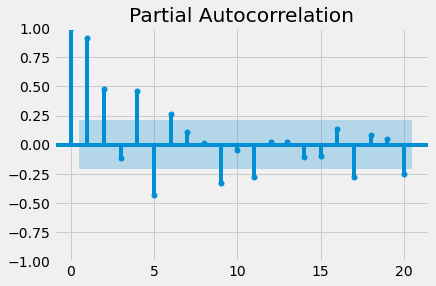

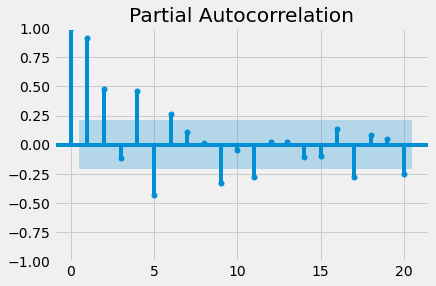

In [ ]:
plot_pacf(data["Revenue"], lags = 20)


In [ ]:
# Now here’s how to train a SARIMA model to predict the quarterly revenue of Adidas:

model=sm.tsa.statespace.SARIMAX(data['Revenue'], trend='c',
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12))
model=model.fit()
print(model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.33268D+00    |proj g|=  1.00154D-01

At iterate    5    f=  6.27606D+00    |proj g|=  3.21191D-02


 This problem is unconstrained.



At iterate   10    f=  6.27158D+00    |proj g|=  4.12965D-03

At iterate   15    f=  6.27140D+00    |proj g|=  2.73259D-03

At iterate   20    f=  6.26653D+00    |proj g|=  1.45614D-02

At iterate   25    f=  6.26380D+00    |proj g|=  1.19045D-03

At iterate   30    f=  6.25953D+00    |proj g|=  2.63754D-02

At iterate   35    f=  6.22543D+00    |proj g|=  4.03308D-03
                                     SARIMAX Results                                      
Dep. Variable:                            Revenue   No. Observations:                   88
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -547.834
Date:                            Mon, 03 Oct 2022   AIC                           1107.669
Time:                                    19:43:34   BIC                           1121.574
Sample:                                         0   HQIC                          1113.221
                                             - 88                                 

In [ ]:
# Now let’s forecast the quarterly revenue of Adidas for the next eight quarters:

predictions = model.predict(len(data), len(data)+7)
print(predictions)

88    5895.666424
89    5557.177401
90    6680.239748
91    6091.189254
92    6563.131031
93    6002.736464
94    6926.402994
95    6392.213311
Name: predicted_mean, dtype: float64


<AxesSubplot:>

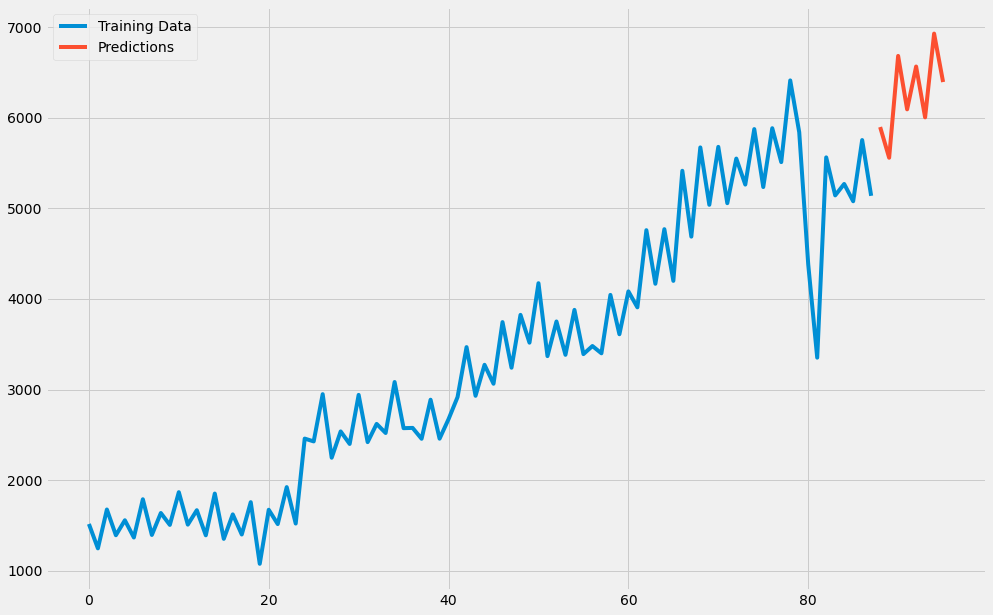

In [ ]:
# Here’s how we can plot the predictions:
data["Revenue"].plot(legend=True, 
                     label="Training Data", 
                     figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")


# Conclusiones

